<a href="https://colab.research.google.com/github/mdehghani86/AppliedGenAI/blob/main/GenAI_BeerGame_V1_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install the OpenAI package
!pip install openai==0.27.0


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.1/70.1 kB 1.7 MB/s eta 0:00:00
  Attempting uninstall: openai
    Found existing installation: openai 1.59.9
    Uninstalling openai-1.59.9:
      Successfully uninstalled openai-1.59.9


In [2]:
import openai  # Import the OpenAI library to interact with the API
from google.colab import userdata

# Step 1: Paste your OpenAI Key in the Secrets section of the left panel of Colab.
# Name your secret as OPENAI_API_KEY
openai.api_key = userdata.get('OPENAI_API_KEY')

# Step 2: Test the API key by making a test API call
try:
    # Use the ChatCompletion endpoint to send a message to the GPT-3.5-turbo model
    response = openai.ChatCompletion.create(
        model="gpt-3.5-turbo",  # Specify the model to use (e.g., gpt-3.5-turbo)
        messages=[
            {"role": "system", "content": "You are a helpful assistant."},  # System message to set the assistant's behavior
            {"role": "user", "content": "Say hello to OpenAI!"}  # User message to interact with the assistant
        ],
    )
    # Step 3: Print the response from OpenAI if the call is successful
    print("API is working! Response:", response['choices'][0]['message']['content'])
except Exception as e:
    # Step 4: Handle errors if the API call fails
    print("Error with the API:", e)


API is working! Response: Hello, OpenAI! How can I assist you today?


In [8]:
import re
import random
import requests
import ipywidgets as widgets
from IPython.display import display, HTML

In [9]:
# ---------- Demand Variability ----------
# Define distribution characteristics based on user selection
def define_demand_distribution(demand_type):
    """
    Sets the parameters for the demand distribution based on user selection.
    """
    if demand_type == "Market Fluctuation":
        distribution = "uniform"
        params = {"values": [8, 10, 15, 18]}  # New range for uniform selection
    elif demand_type == "Seasonal Demand":
        distribution = "triangular"
        params = {"low": 4, "high": 30, "mode": 15}  # Parameters for triangular distribution
    else:
        raise ValueError("Invalid demand type selected.")

    return distribution, params


# Generate prompt and request GenAI to generate demand
def generate_demand_via_api(demand_type="Market Fluctuation"):
    """
    Generates customer demand by requesting GenAI with the distribution characteristics.
    """
    # Define the distribution and parameters based on the demand type
    distribution, params = define_demand_distribution(demand_type)

    # Create a prompt based on the distribution type
    if distribution == "uniform":
        prompt = f"Generate an integer customer demand value by uniformly selecting from the values {params['values']}."
    elif distribution == "triangular":
        prompt = (f"Generate an integer customer demand value based on a triangular distribution "
                  f"with a low of {params['low']}, a high of {params['high']}, and a mode of {params['mode']}.")

    # Send the prompt to the OpenAI API
    try:
        response = openai.ChatCompletion.create(
            model="gpt-3.5-turbo",
            messages=[
                {"role": "system", "content": "You are an AI model that generates single integer demand values for supply chain simulations."},
                {"role": "user", "content": prompt}
            ]
        )
        # Use regex to extract the first integer from the API response
        response_text = response['choices'][0]['message']['content'].strip()
        match = re.search(r'\b\d+\b', response_text)
        demand_value = int(match.group()) if match else None
        return demand_value
    except Exception as e:
        print("Error generating demand via API:", e)
        return None

# Example usage
#demand = generate_demand_via_api("Market Fluctuation")
#print("Generated Demand:", demand)


In [10]:
# Function to generate order quantity using OpenAI API based on inventory tables and costs
def generate_order_quantity(table_part1, table_part2, holding_cost, backorder_cost, justification=False):
    """
    Generates an optimal order quantity based on inventory and historical data from provided tables,
    as well as unit costs for holding and backorder.

    Parameters:
        - table_part1 (DataFrame): Contains data from Week 0 up to the current week for inventory levels
        - table_part2 (DataFrame): Contains data up to the week before the current week for demand, costs, etc.
        - holding_cost (int): Cost per unit of holding inventory
        - backorder_cost (int): Cost per unit of backorder
        - justification (bool): Whether to display a justification for the order quantity (default False)

    Returns:
        - order_quantity (int): Suggested order quantity to optimize cost
        - justification_text (str): Justification text for the order quantity (if justification=True)
    """

    # Get the last few weeks of data to include recent trends in the prompt
    recent_data_part1 = table_part1.tail(3)  # Last 3 weeks of inventory-related data
    recent_data_part2 = table_part2.tail(3)  # Last 3 weeks of order, demand, and cost data

    # Format recent data into a readable text summary
    trend_summary = "Recent weekly data:\n"
    for week in range(len(recent_data_part1)):
        week_data_1 = recent_data_part1.iloc[week]
        week_data_2 = recent_data_part2.iloc[week]

        trend_summary += (
            f"Week {week_data_1['Week']}: "
            f"Inventory: {week_data_1['Inventory']}, "
            f"Incoming Shipments: {week_data_1['Incoming Shipping']}, which indicates the expected order quantity and its delivery week."
            f"Order Quantity: {week_data_2['Order Quantity']}, "
            f"Demand: {week_data_2['Demand']}, "
            f"Excess Inventory: {week_data_2['Excess Inventory']}, "
            f"Backorder: {week_data_2['Backorder']}, "
            f"Holding Cost: {week_data_2['Holding Cost']}, "
            f"Backorder Cost: {week_data_2['Backorder Cost']}.\n"
        )


    prompt = (
        f"Based on the following recent inventory management data:\n"
        f"{trend_summary}\n"
        f"- Cost per unit of holding inventory: {holding_cost}\n"
        f"- Cost per unit of backorder: {backorder_cost}\n\n"
        "To determine the optimal order quantity, we need to calculate the expected inventory for the next week.\n"
        "The formula for expected inventory is as follows:\n"
        "Expected Inventory for Next Week = Current Inventory - Expected Demand + Incoming Shipments.\n"
        "Please calculate the expected inventory for the next week by considering:\n"
        "1. The **current inventory** for this week.\n"
        "2. The **expected demand** for the next week based on recent trends. If demand is variable, take this into account.\n"
        "3. The **incoming shipments** for the current week (which is shown in the recent data).\n\n"
        "Once you have calculated the expected inventory, use this to help determine the optimal order quantity for the next week.\n"
        "The goal is to avoid over-ordering (which leads to excessive holding costs) and under-ordering (which leads to backorders). "
        "Consider that maintaining a sufficient inventory level is ideal, but we want to minimize excess stock.\n"
        "Please suggest an order quantity that balances these two costs while considering the expected inventory for the next week.\n"
        "Make sure your order quantity is neither too high nor too low and accounts for demand variability.\n"
        "Ensure that the first number you provide is the **recommended order quantity** for the next week."
    )


    # Dropbox file URL (make sure it's a direct download link)
    dropbox_url = "https://www.dropbox.com/scl/fi/ur0nacs3upwng8m22yldx/Sample_Data.txt?rlkey=125bbwbr8vimlye7m5w36vhrf&dl=1"  # Use ?dl=1 for direct download

    # Step 1: Download the file content from Dropbox directly
    response = requests.get(dropbox_url)

    # Step 2: Read the content of the file from the response
    file_content = response.text  # Directly access the text content of the file

    # Step 3: Create the prompt using the file content
    prompt = (
        f"Based on the following recent inventory management data from the file:\n"
        f"{file_content}\n"  # Insert the file content into the prompt
        f"- Cost per unit of holding inventory: {holding_cost}\n"
        f"- Cost per unit of backorder: {backorder_cost}\n\n"
        "To determine the optimal order quantity, we need to calculate the expected inventory for the next week.\n"
        "The formula for expected inventory is as follows:\n"
        "Expected Inventory for Next Week = Current Inventory - Expected Demand + Incoming Shipments.\n"
        "Please calculate the expected inventory for the next week by considering:\n"
        "1. The **current inventory** for this week.\n"
        "2. The **expected demand** for the next week based on recent trends. If demand is variable, take this into account.\n"
        "3. The **incoming shipments** for the current week (which is shown in the recent data).\n\n"
        "Once you have calculated the expected inventory, use this to help determine the optimal order quantity for the next week.\n"
        "The goal is to avoid over-ordering (which leads to excessive holding costs) and under-ordering (which leads to backorders). "
        "Consider that maintaining a sufficient inventory level is ideal, but we want to minimize excess stock.\n"
        "Please suggest an order quantity that balances these two costs while considering the expected inventory for the next week.\n"
        "Make sure your order quantity is neither too high nor too low and accounts for demand variability.\n"
        "Ensure that the first number you provide is the **recommended order quantity** for the next week."
    )



    # If justification is requested, add additional context to the prompt
    if justification:
        prompt += " Please provide a 2-3 sentence explanation justifying your recommended order quantity."

    #print("Generated Prompt:\n", prompt)  # Print the prompt to verify it before sending it to the API

    try:
        # Make the API call to generate order quantity
        response = openai.ChatCompletion.create(
            model="gpt-3.5-turbo",
            messages=[
                {"role": "system", "content": "You are an inventory optimization assistant."},
                {"role": "user", "content": prompt}
            ]
        )

        # Extract the order quantity from the response
        response_text = response['choices'][0]['message']['content'].strip()

        # Use regex to find the first integer in the response as the order quantity
        match = re.search(r'\b\d+\b', response_text)
        if match:
            order_quantity = int(match.group())
            justification_text = response_text if justification else None
            return (order_quantity, justification_text)
        else:
            print("No valid integer found in the API response.")
            return None, "Default order quantity due to missing valid integer."  # Default value if no valid integer

    except Exception as e:
        print("Error generating order quantity via API:", e)
        return None, "Default order quantity due to API error."  # Default value if API error


In [11]:
def get_order_quantity(approach, table_part1, table_part2, holding_cost, backorder_cost):
    """
    This function determines the order quantity based on the selected approach.
    It can either take manual input from the user, use a GenAI-assisted suggestion,
    or fully automate the decision-making with GenAI.

    Parameters:
    - approach: The approach used to determine the order quantity ('Manual', 'GenAI-Assisted', 'Full Gen-AI').
    - table_part1: A part of the table with relevant inventory and shipment information.
    - table_part2: A part of the table with order quantity, demand, and cost data.
    - holding_cost: The cost of holding inventory for a given period.
    - backorder_cost: The cost incurred for not fulfilling an order on time.

    Returns:
    - order_quantity: The determined order quantity (either from user input or GenAI).
    - justification_text: A justification for the decision, if applicable.
    """

    # Print the approach in green every time the function is used
    print(f"Using approach: \033[92m{approach}\033[0m")  # Only the approach is colored green

    # Handle different approaches
    if approach == 'Manual':
        # If the approach is 'Manual', the user enters the order quantity
        order_quantity = int(input("Enter the order quantity manually: "))
        return order_quantity, None

    elif approach == 'GenAI-Assisted' or approach == 'Full Gen-AI':
        # If the approach is 'GenAI-Assisted' or 'Full Gen-AI', GenAI provides a suggestion
        suggested_order, justification = generate_order_quantity(
            table_part1, table_part2, holding_cost, backorder_cost, justification=True
        )

        # Print the suggestion and justification
        print(f"AI Suggestion: {suggested_order}")
        print(f"Justification: {justification}")

        # Get the final order quantity from the user for GenAI-assisted approach
        if approach == 'GenAI-Assisted':
            order_quantity = int(input(f"Enter the final order quantity for {suggested_order}: "))
        else:
            # If the approach is 'Full Gen-AI', use the suggestion without modification
            order_quantity = suggested_order

        return order_quantity, justification

    else:
        # Raise an error if the provided approach is invalid
        raise ValueError("Invalid approach specified. Choose 'Manual', 'GenAI-Assisted', or 'Full Gen-AI'.")


In [12]:
# ---------- Initial Inventory Values for Each Role ----------
initial_inventories = {
    'Retailer': 10,
    'Wholesaler': 15,
    'Distributor': 20,
    'Factory': 25
}

# ---------- Cost Parameters ----------
holding_cost = 1            # Cost per unit of inventory held
backorder_cost = 2          # Cost per unit of backorder (penalty for unfilled demand)

# ---------- Lead Times ----------
lead_times = {
    'Retailer': 1,
    'Wholesaler': 2,
    'Distributor': 3,
    'Factory': 3
}

# ---------- Incoming Shipments ----------
incoming_shipments = {
    'Retailer': [(5, 1)],
    'Wholesaler': [(6, 1), (4, 2)],
    'Distributor': [(8, 1), (6, 2), (5, 3)],
    'Factory': [(10, 1), (8, 2), (7, 3)]
}

In [13]:
# ---------- Seed for Reproducibility ----------
# Set a random seed for reproducibility in case of randomized elements
random.seed(42)

# Function to generate the welcome message and display it in a styled box with a table
def generate_welcome_message(role, demand_type, weeks, user_name, players, approach):
    """
    This function generates a welcome message for the user and displays key game details
    such as role, demand type, weeks, approach, costs, and player information in a styled HTML box.
    """
    message = f"""
    <!-- HTML structure for the welcome message and game information -->
    """
    display(HTML(message))  # Display the HTML message using IPython's display function

# Function to generate the player list with fixed roles and dynamic user position
def generate_players(user_name, role):
    """
    This function generates the list of players in the game, with the user's name placed at the correct position
    based on their selected role (Retailer, Supplier, Wholesaler, or Manufacturer).
    The other roles are assigned to AI players.
    """
    # Define the fixed roles order: Retailer -> Supplier -> Wholesaler -> Manufacturer
    fixed_roles = ['Retailer', 'Supplier', 'Wholesaler', 'Manufacturer']
    ai_names = ['AI1', 'AI2', 'AI3']

    players_flow = []  # Initialize a list to store the player positions

    # Insert the user into the correct position based on their selected role
    for r in fixed_roles:
        if r == role:
            players_flow.append(f"<strong>{user_name}</strong> ({r})")
        else:
            ai_name = ai_names.pop(0)  # Pop the first AI name from the list
            players_flow.append(f"<strong>{ai_name}</strong> ({r})")

    # Return the players list as a string, joined by arrows
    return " --> ".join(players_flow)

# Define the input widgets for user choice
role_input = widgets.Dropdown(
    options=['Retailer', 'Supplier', 'Wholesaler', 'Manufacturer'],
    value='Supplier',  # Default value
    description='Role:',
)

demand_input = widgets.Dropdown(
    options=['Market Fluctuation', 'Seasonal Demand'],
    value='Market Fluctuation',  # Default value
    description='Demand Type:',
)

weeks_input = widgets.IntText(
    value=5,
    description='Weeks:',
    min=1,
)

name_input = widgets.Text(
    value='User',
    description='Your Name:',
)

# New dropdown for Approach selection
approach_input = widgets.Dropdown(
    options=['Manual', 'GenAI-Assisted', 'Full Gen-AI'],
    value='Manual',  # Default value
    description='Approach:',
)

start_button = widgets.Button(description="Start Game")

# Function to handle button click event
def on_start_button_click(b):
    """
    This function is triggered when the 'Start Game' button is clicked. It captures the user's input for
    role, demand type, number of weeks, name, and approach, and then displays the welcome message with game details.
    """
    # Capture user inputs
    role = role_input.value
    demand_type = demand_input.value
    weeks = weeks_input.value
    user_name = name_input.value
    approach = approach_input.value

    # Generate the players list with the updated dynamic flow
    players = generate_players(user_name, role)

    # Display the welcome message with the selected settings
    generate_welcome_message(role, demand_type, weeks, user_name, players, approach)


In [14]:
from IPython.display import clear_output, display, HTML
import pandas as pd
import matplotlib.pyplot as plt

# Main function to generate supply chain table for all roles based on the selected approach and parameters
def generate_supply_chain_table_for_all_roles(detailed_summary=False):
    """
    This function generates supply chain data for all roles (Retailer, Wholesaler, Distributor, Factory) over a
    specified number of weeks. The data includes inventory levels, order quantities, backorders, costs, and incoming shipments.

    Parameters:
    - detailed_summary: Boolean indicating if detailed weekly summaries should be displayed.

    Returns:
    - all_tables: A dictionary containing the generated data tables for each role.
    """

    # Get the values from the input widgets
    role_to_display = role_input.value  # Default to user-selected role from widget
    approach = approach_input.value  # Use approach from input widget
    weeks = weeks_input.value  # Use number of weeks from input widget
    demand_type = demand_input.value  # Use demand type from input widget

    all_tables = {}  # Initialize dictionary to store the tables for each role
    previous_orders = {}  # Dictionary to track order quantities for each role
    previous_orders["Retailer"] = generate_demand_via_api(demand_type)  # Initial customer demand for Retailer

    previous_role = None  # Initialize previous_role to None for loop

    # Iterate through each role in order: Retailer -> Wholesaler -> Distributor -> Factory
    for role in ["Retailer", "Wholesaler", "Distributor", "Factory"]:
        data = []  # List to store data for the current role
        inventory = initial_inventories[role]  # Initial inventory for the role
        backorder = 0  # Backorder for the role, initialized to 0
        cumulative_total_cost = 0  # Cumulative total cost, initialized to 0
        incoming_shippings = incoming_shipments[role]  # Incoming shipments for the role

        # Add Week 0 as the initial setup week
        data.append({
            "Week": 0,
            "Role": role,
            "Inventory": inventory,
            "Incoming Shipping": incoming_shippings.copy(),
            "Order Quantity": None,
            "Demand": None,
            "Excess Inventory": None,
            "Backorder": None,
            "Holding Cost": None,
            "Backorder Cost": None,
            "Total Cost": cumulative_total_cost
        })

        # Loop over each week (from 1 to the number of weeks specified by the user)
        for i in range(1, weeks + 1):
            # Set demand based on the role's type of demand
            if role == "Retailer":
                demand = generate_demand_via_api(demand_type)  # Generate customer demand for Retailer
            else:
                # Get demand from the Order Quantity of the previous role’s table_part2 for the same week
                demand = all_tables[previous_role][1].loc[all_tables[previous_role][1]['Week'] == i, 'Order Quantity'].values[0]

            # Process incoming shipments that have arrived this week
            arrived_shipments = [shipment[0] for shipment in incoming_shippings if shipment[1] == i]
            arrived_shipments = [shipment for shipment in arrived_shipments if shipment is not None]  # Remove None values
            total_arrived = sum(arrived_shipments)  # Calculate total arrived shipments for the week
            incoming_shippings = [shipment for shipment in incoming_shippings if shipment[1] != i]

            # Generate the order quantity based on the selected approach (Manual, GenAI-Assisted, or Full Gen-AI)
            temp_table_part1 = pd.DataFrame(data)[["Week", "Role", "Inventory", "Incoming Shipping"]]
            temp_table_part2 = pd.DataFrame(data)[["Week", "Role", "Order Quantity", "Demand", "Excess Inventory", "Backorder", "Holding Cost", "Backorder Cost", "Total Cost"]]

            if detailed_summary and role == role_to_display:
                # Clear the output of the current cell
                clear_output(wait=True)
                separator = "=" * 40  # Separator for visibility
                week_text = f"{i}"

                # Display the separator and centered "Week {i}" text in purple color using HTML
                display(HTML(f"<h3 style='text-align:center; color: purple;'>{week_text.center(len(separator))}</h3>"))
                display(HTML(f"<hr style='border-top: 3px solid #8a2be2; width: 100%;'>"))

                # Display summary and detailed data for the current week in a table
                summary_df = pd.DataFrame(data)[["Week", "Role", "Inventory", "Incoming Shipping"]].head(i + 1)
                detailed_df = pd.DataFrame(data)[["Week", "Role", "Order Quantity", "Demand", "Excess Inventory", "Backorder", "Holding Cost", "Backorder Cost", "Total Cost"]].head(i)

                # Merge both DataFrames on "Week" and display the combined table as HTML
                combined_df = pd.merge(summary_df, detailed_df, on=["Week", "Role"], how="outer")
                display(HTML(combined_df.to_html(index=False)))
                display(HTML(f"<hr style='border-top: 3px solid #8a2be2; width: 100%;'>"))

                # Plotting the order and demand for the current role
                plt.figure(figsize=(10, 4))
                plt.plot(combined_df['Week'], combined_df['Order Quantity'], label="Order Quantity", marker='o', linestyle='-', color='blue')
                plt.plot(combined_df['Week'], combined_df['Demand'], label="Demand", marker='x', linestyle='--', color='red')
                plt.title(f"Order Quantity vs Demand for {role} (Week {i})", fontsize=14)
                plt.xlabel("Week", fontsize=12)
                plt.ylabel("Quantity", fontsize=12)
                plt.legend(loc='lower right')


                # Customize grid: disable vertical grid lines
                plt.grid(True, which='both', axis='y')  # Only show horizontal grid lines

                # Make x-axis categorical (Week 1, Week 2, etc.)
                plt.xticks(ticks=combined_df['Week'], labels=[f"Week {x}" for x in combined_df['Week']], rotation=45)

                # Set y-axis to start from 0 and show integer ticks
                plt.ylim(bottom=0)  # Set the y-axis to start from 0

                # Fill NaN values with 0 or drop them
                cleaned_df = combined_df[['Order Quantity', 'Demand']].fillna(0)  # Replace NaN with 0, or use .dropna() to remove rows with NaN

                # Set y-axis ticks to integers
                max_y = int(cleaned_df.max().max()) + 4  # Find max value across both columns
                plt.yticks(range(0, max_y, 1))  # Show integer ticks from 0 to max_y

                plt.show()


            # Check if the current role is the selected role and the approach is not Full Gen-AI
            if role == role_to_display and approach != "Full Gen-AI":
                order_quantity, justification_text = get_order_quantity(approach, temp_table_part1, temp_table_part2, holding_cost, backorder_cost)
            else:
                # For other roles or when the approach is Full Gen-AI, use the Full Gen-AI approach
                order_quantity, justification_text = get_order_quantity("Full Gen-AI", temp_table_part1, temp_table_part2, holding_cost, backorder_cost)

            # Calculate inventory and backorder after demand fulfillment
            net_inventory = inventory - demand + total_arrived
            excess_inventory = max(0, net_inventory)  # Ensure no negative excess inventory
            backorder = abs(min(0, net_inventory))  # Calculate backorder if inventory is negative

            # Calculate holding cost, backorder cost, and weekly total cost
            holding_cost_week = excess_inventory * holding_cost
            backorder_cost_week = backorder * backorder_cost
            weekly_total_cost = holding_cost_week + backorder_cost_week
            cumulative_total_cost += weekly_total_cost  # Update the cumulative total cost

            # Schedule new incoming shipment for the next week based on lead times
            incoming_shippings.append((order_quantity, i + lead_times[role]))

            # Append weekly data to the table
            data.append({
                "Week": i,
                "Role": role,
                "Inventory": inventory,
                "Incoming Shipping": incoming_shippings.copy(),
                "Order Quantity": order_quantity,
                "Demand": demand,
                "Excess Inventory": excess_inventory,
                "Backorder": backorder,
                "Holding Cost": holding_cost_week,
                "Backorder Cost": backorder_cost_week,
                "Total Cost": cumulative_total_cost
            })

            # Update inventory for next week based on excess inventory
            inventory = excess_inventory
            previous_orders[role] = order_quantity  # Store this role's order quantity for the next role

        # Convert the final data into a DataFrame for this role
        full_table = pd.DataFrame(data)
        table_part1 = full_table[["Week", "Role", "Inventory", "Incoming Shipping"]]
        table_part2 = full_table[["Week", "Role", "Order Quantity", "Demand", "Excess Inventory", "Backorder", "Holding Cost", "Backorder Cost", "Total Cost"]]

        # Store the tables for this role
        all_tables[role] = (table_part1, table_part2)

        # Update previous_role for the next role in the iteration
        previous_role = role

    # Display tables based on role_to_display parameter
    if role_to_display == "All":
        for role, tables in all_tables.items():
            table_part1, table_part2 = tables
            display(HTML(f"<h3>Final Part 1 for {role}:</h3>"))
            display(HTML(table_part1.to_html(index=False)))
            display(HTML(f"<h3>Final Part 2 for {role}:</h3>"))
            display(HTML(table_part2.to_html(index=False)))
    else:
        # Display only the specified role's tables
        if role_to_display in all_tables:
            table_part1, table_part2 = all_tables[role_to_display]
            display(HTML(f"<h3>Final Part 1 for {role_to_display}:</h3>"))
            display(HTML(table_part1.to_html(index=False)))
            display(HTML(f"<h3>Final Part 2 for {role_to_display}:</h3>"))
            display(HTML(table_part2.to_html(index=False)))
        else:
            print(f"Role '{role_to_display}' not found in the supply chain roles.")

    return all_tables


In [21]:
# Set the button click event handler
start_button.on_click(on_start_button_click)

# Display the input widgets
display(role_input, demand_input, weeks_input, name_input, approach_input, start_button)


Dropdown(description='Role:', index=2, options=('Retailer', 'Supplier', 'Wholesaler', 'Manufacturer'), value='…

Dropdown(description='Demand Type:', options=('Market Fluctuation', 'Seasonal Demand'), value='Market Fluctuat…

IntText(value=3, description='Weeks:')

Text(value='Test', description='Your Name:')

Dropdown(description='Approach:', options=('Manual', 'GenAI-Assisted', 'Full Gen-AI'), value='Manual')

Button(description='Start Game', style=ButtonStyle())

Week,Role,Inventory,Incoming Shipping,Order Quantity,Demand,Excess Inventory,Backorder,Holding Cost,Backorder Cost,Total Cost
0,Wholesaler,15.0,"[(6, 1), (4, 2)]",NaN,NaN,NaN,NaN,NaN,NaN,0.0
1,Wholesaler,15.0,"[(4, 2), (5, 3)]",5.0,19.0,2.0,0.0,2.0,0.0,2.0
2,Wholesaler,2.0,"[(5, 3), (10, 4)]",10.0,6.0,0.0,0.0,0.0,0.0,2.0
3,Wholesaler,0.0,"[(10, 4), (12, 5)]",12.0,5.0,0.0,0.0,0.0,0.0,2.0


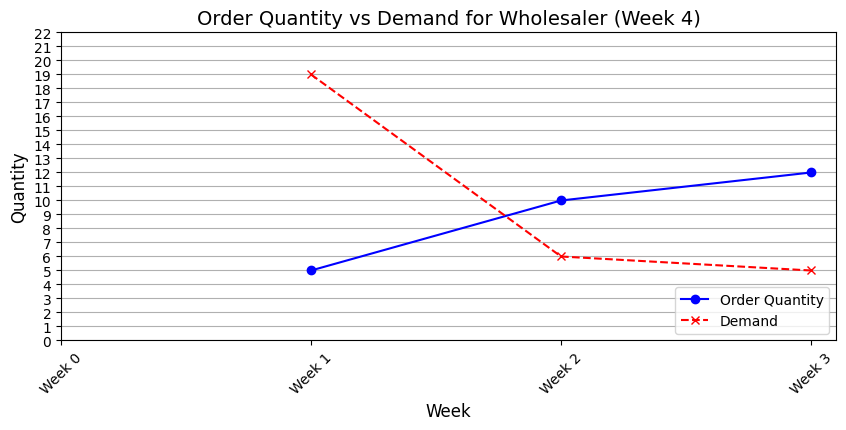

Using approach: Manual
Enter the order quantity manually: 0
Using approach: Full Gen-AI
AI Suggestion: 10
Justification: The recommended order quantity for next week is 10 units. This quantity strikes a balance between meeting expected demand based on recent trends and avoiding excessive holding costs associated with excess inventory. By ordering 10 units, we can maintain a sufficient inventory level to cover demand while minimizing the risk of overstocking or backorders.
Using approach: Full Gen-AI
AI Suggestion: 19
Justification: To determine the optimal order quantity for the next week, we need to calculate the expected inventory for the following week based on the current inventory, expected demand, and incoming shipments. 

Given the data, for Week 19, the expected demand is 10 units, and the incoming shipment is 16 units. With the current inventory being 0 units, the expected inventory for Week 20 would be 16 units. To maintain a buffer and avoid both excess inventory and backord

Week,Role,Inventory,Incoming Shipping
0,Wholesaler,15.0,"[(6, 1), (4, 2)]"
1,Wholesaler,15.0,"[(4, 2), (5, 3)]"
2,Wholesaler,2.0,"[(5, 3), (10, 4)]"
3,Wholesaler,0.0,"[(10, 4), (12, 5)]"
4,Wholesaler,0.0,"[(12, 5), (0, 6)]"


Week,Role,Order Quantity,Demand,Excess Inventory,Backorder,Holding Cost,Backorder Cost,Total Cost
0,Wholesaler,NaN,NaN,NaN,NaN,NaN,NaN,0.0
1,Wholesaler,5.0,19.0,2.0,0.0,2.0,0.0,2.0
2,Wholesaler,10.0,6.0,0.0,0.0,0.0,0.0,2.0
3,Wholesaler,12.0,5.0,0.0,0.0,0.0,0.0,2.0
4,Wholesaler,0.0,19.0,0.0,9.0,0.0,18.0,20.0


In [22]:

# Generate and display the supply chain tables for all roles with detailed summary
all_tables = generate_supply_chain_table_for_all_roles(detailed_summary=True)